In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def bgtm_npz_to_ci_df(npz_path, metric="kld", cred_level=0.90):
    npz = np.load(npz_path, allow_pickle=False)
    arr = npz[metric]                # [S, n_pairs]
    pair_index = npz["pair_index"]    # [n_pairs, 2]

    alpha = 1 - cred_level
    q_lo, q_hi = alpha/2, 1 - alpha/2

    mean = arr.mean(axis=0)
    lo   = np.quantile(arr, q_lo, axis=0)
    hi   = np.quantile(arr, q_hi, axis=0)

    df = pd.DataFrame({
        "var_row": pair_index[:,0].astype(int),
        "var_col": pair_index[:,1].astype(int),
        "pair": [f"{int(a)}-{int(b)}" for a,b in pair_index],
        "mean": mean, "lo": lo, "hi": hi
    })
    return df

def add_pair_col(df):
    if "pair" not in df.columns:
        df["pair"] = df["var_row"].astype(int).astype(str) + "-" + df["var_col"].astype(int).astype(str)
    return df

def plot_compare_bgtm_ci_vs_gtm(
    bgtm_ci_df,
    gtm_df,
    truth_df=None,
    metric_bgtm="kld",
    metric_gtm="kld",
    top_k=25,
    sort_by="bgtm_mean",
):
    bgtm_ci_df = add_pair_col(bgtm_ci_df.copy())
    gtm_df     = add_pair_col(gtm_df.copy())
    if truth_df is not None:
        truth_df = add_pair_col(truth_df.copy())

    # align on common pairs
    common = set(bgtm_ci_df["pair"]) & set(gtm_df["pair"])
    if truth_df is not None:
        common &= set(truth_df["pair"])
    common = sorted(common)

    b = bgtm_ci_df.set_index("pair").loc[common]
    g = gtm_df.set_index("pair").loc[common]
    t = truth_df.set_index("pair").loc[common] if truth_df is not None else None

    # choose pairs to show
    if sort_by == "bgtm_mean":
        pairs = b.sort_values("mean", ascending=False).head(top_k).index.tolist()
    elif sort_by == "gtm":
        pairs = g.sort_values(metric_gtm, ascending=False).head(top_k).index.tolist()
    else:
        pairs = common[:top_k]

    b = b.loc[pairs]
    g = g.loc[pairs]
    if t is not None:
        t = t.loc[pairs]

    x = np.arange(len(pairs))

    plt.figure(figsize=(max(10, len(pairs)*0.6), 5))

    # BGTM: mean line + CI band
    plt.plot(x, b["mean"].values, linewidth=2)
    plt.fill_between(x, b["lo"].values, b["hi"].values, alpha=0.2)

    # GTM: point estimates as markers
    plt.scatter(x, g[metric_gtm].values, s=25)

    # Truth: if you have a “true metric per pair” you can scatter too.
    # If truth_df is just dependence labels (0/1), then plot it on a secondary axis instead (below).
    if t is not None and metric_gtm in t.columns:
        plt.scatter(x, t[metric_gtm].values, s=25)

    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xticks(x, pairs, rotation=45, ha="right")
    plt.ylabel(metric_bgtm)
    plt.title(f"{metric_bgtm}: BGTM CI band + GTM points (top {top_k} pairs)")
    plt.tight_layout()
    plt.show()


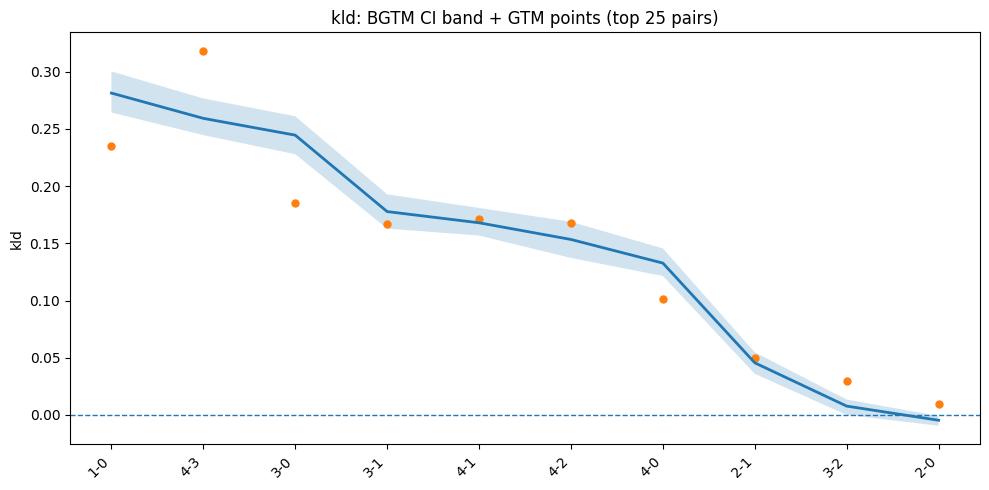

In [5]:
run_dir = Path("/Users/franciscocapunay/Downloads/gtm_server_copy/mlruns/rine_5D_1000obs_bgtm_test_1/fc1d566421714258b1cefdc93da19984/artifacts")

bgtm_npz = run_dir / "gtm_bayes/ci_raw/bgtm_ci_raw_arrays.npz"
gtm_csv  = run_dir / "gtm_freq/ci_tables/ci_table_gtm.csv"
truth_csv = run_dir / "truth/true_structure.csv"   # optional

bgtm_ci = bgtm_npz_to_ci_df(bgtm_npz, metric="kld", cred_level=0.90)
gtm_df  = pd.read_csv(gtm_csv)

truth_df = pd.read_csv(truth_csv)  # has dependence 0/1
# (truth_df doesn’t have kld/iae; it’s just dependence labels)

plot_compare_bgtm_ci_vs_gtm(bgtm_ci, gtm_df, truth_df=None, metric_bgtm="kld", metric_gtm="kld", top_k=25)


In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("/Users/franciscocapunay/Downloads/gtm_server_copy")  # <- your rsync root

BGTM_NPZ_REL = Path("artifacts/gtm_bayes/ci_raw/bgtm_ci_raw_arrays.npz")
GTM_CSV_REL  = Path("artifacts/gtm_freq/ci_tables/ci_table_gtm.csv")  # <- adjust if different

cred_level = 0.90
alpha = 1.0 - cred_level
q_lo, q_hi = alpha/2, 1 - alpha/2


def bgtm_npz_to_ci_df(npz_path: Path, metric="kld") -> pd.DataFrame:
    npz = np.load(npz_path, allow_pickle=False)
    arr = npz[metric]                 # [S, n_pairs]
    pair_index = npz["pair_index"]     # [n_pairs, 2]
    mean = arr.mean(axis=0)
    lo   = np.quantile(arr, q_lo, axis=0)
    hi   = np.quantile(arr, q_hi, axis=0)
    df = pd.DataFrame({
        "var_row": pair_index[:, 0].astype(int),
        "var_col": pair_index[:, 1].astype(int),
        "pair": [f"{int(a)}-{int(b)}" for a, b in pair_index],
        "mean": mean, "lo": lo, "hi": hi
    })
    return df


def add_pair_col(df: pd.DataFrame) -> pd.DataFrame:
    if "pair" not in df.columns:
        df["pair"] = df["var_row"].astype(int).astype(str) + "-" + df["var_col"].astype(int).astype(str)
    return df


# Find all runs that contain BGTM NPZ
bgtm_npzs = list(ROOT.rglob(str(BGTM_NPZ_REL)))
print("BGTM NPZ files found:", len(bgtm_npzs))

# Map run_dir -> paths
runs = []
for npz_path in bgtm_npzs:
    run_dir = npz_path.parents[len(BGTM_NPZ_REL.parts)]  # backs up to <run_id> folder
    gtm_csv = run_dir / GTM_CSV_REL
    runs.append({"run_dir": run_dir, "bgtm_npz": npz_path, "gtm_csv": gtm_csv})

print("candidate runs:", len(runs))
print("runs with GTM CSV:", sum(r["gtm_csv"].exists() for r in runs))


BGTM NPZ files found: 41
candidate runs: 41
runs with GTM CSV: 0


In [14]:
def plot_all_runs_bgtm_vs_gtm(
    runs,
    metric_bgtm="kld",          # from NPZ keys: "kld", "iae", "corr_abs", "precision_abs", ...
    metric_gtm="kld",           # column name in GTM csv (your frequentist table uses "kld" and "iae")
    top_k=25,
    sort_by="avg_bgtm_mean",    # "avg_bgtm_mean" or "first_run"
):
    # Load per-run data
    per_run = []
    for r in runs:
        try:
            b = bgtm_npz_to_ci_df(r["bgtm_npz"], metric=metric_bgtm)
            b = add_pair_col(b)

            g = None
            if r["gtm_csv"].exists():
                g = pd.read_csv(r["gtm_csv"])
                g = add_pair_col(g)

            per_run.append({"run_dir": r["run_dir"], "bgtm": b, "gtm": g})
        except Exception:
            pass

    if not per_run:
        print("No runs could be loaded.")
        return

    # Align pairs across runs (and across GTM if present)
    common = set(per_run[0]["bgtm"]["pair"])
    for item in per_run[1:]:
        common &= set(item["bgtm"]["pair"])
    if len(common) == 0:
        print("No common pairs across runs.")
        return
    common = sorted(common)

    # Choose top_k pairs
    if sort_by == "avg_bgtm_mean":
        # average BGTM mean across runs
        score = {}
        for p in common:
            score[p] = float(np.mean([
                item["bgtm"].loc[item["bgtm"]["pair"] == p, "mean"].values[0]
                for item in per_run
            ]))
        pairs = [p for p, _ in sorted(score.items(), key=lambda x: x[1], reverse=True)[:top_k]]
    else:
        # top_k from first run BGTM
        b0 = per_run[0]["bgtm"].set_index("pair").loc[common].sort_values("mean", ascending=False)
        pairs = b0.index[:top_k].tolist()

    x = np.arange(len(pairs))

    plt.figure(figsize=(max(10, len(pairs)*0.6), 5))

    # BGTM: for each run, mean line + CI band
    for item in per_run:
        b = item["bgtm"].set_index("pair").loc[pairs]
        plt.plot(x, b["mean"].values, linewidth=2)
        plt.fill_between(x, b["lo"].values, b["hi"].values, alpha=0.18)

    # GTM: for each run (if exists), scatter points
    any_gtm = any(item["gtm"] is not None for item in per_run)
    if any_gtm:
        for item in per_run:
            if item["gtm"] is None:
                continue
            g = item["gtm"].set_index("pair").loc[pairs]
            if metric_gtm in g.columns:
                plt.scatter(x, g[metric_gtm].values, s=18)

    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(x, np.ones_like(x), linewidth=1)
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_ylabel("truth dependence")

    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xticks(x, pairs, rotation=45, ha="right")
    plt.ylabel(metric_bgtm)
    title = f"All runs: BGTM CI bands + GTM points ({metric_bgtm}), level={cred_level:.2f}"
    if not any_gtm:
        title += "  (GTM CSV not found)"
    plt.title(title)
    plt.tight_layout()
    plt.show()


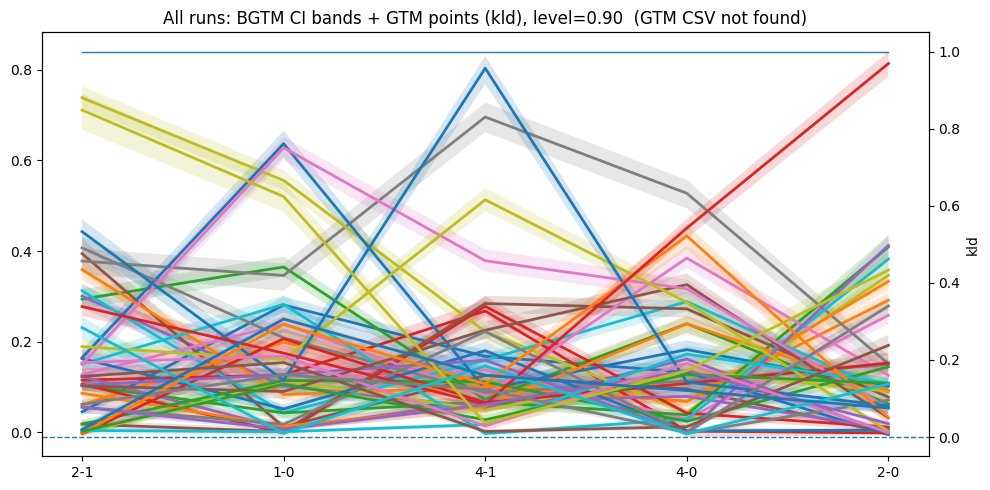

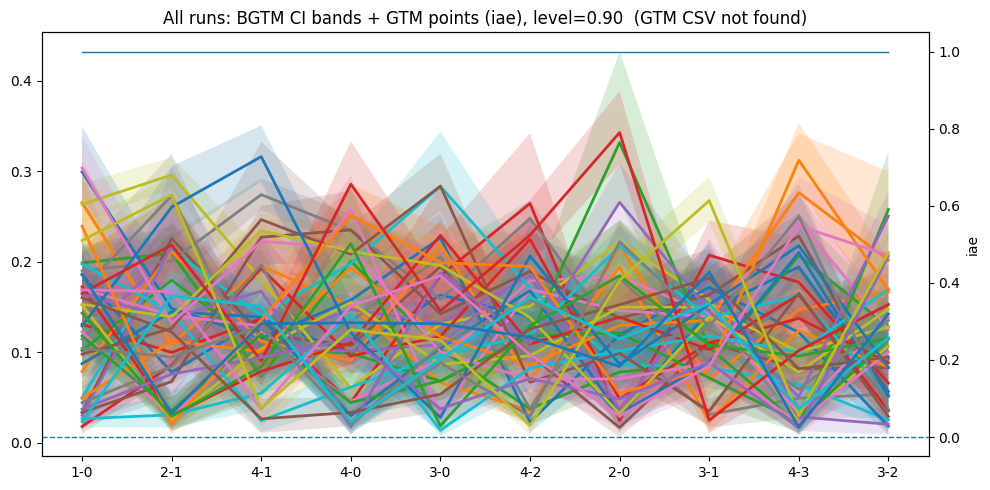

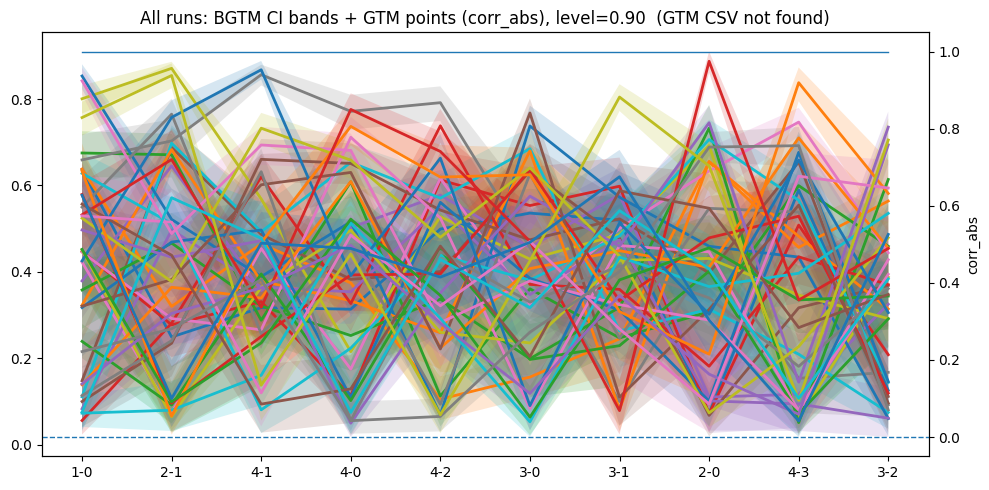

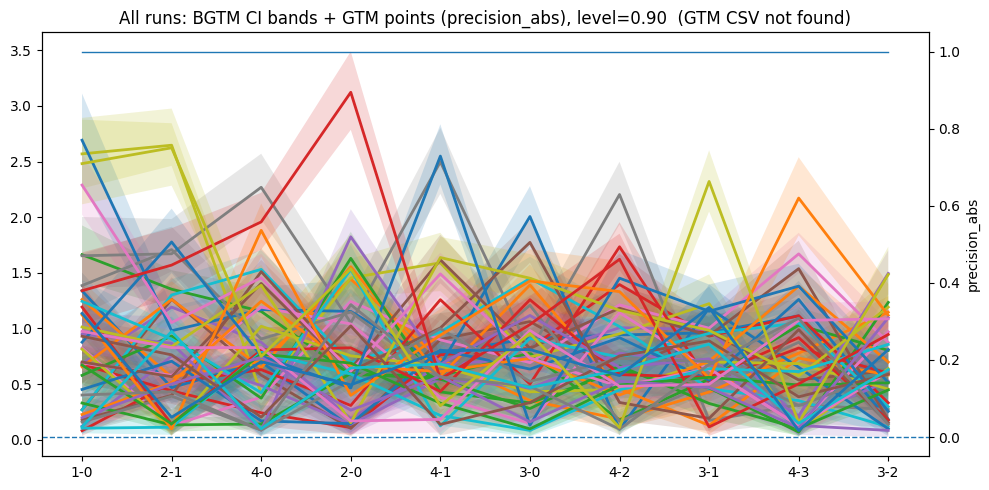

In [16]:
plot_all_runs_bgtm_vs_gtm(runs, metric_bgtm="kld", metric_gtm="kld", top_k=25)
plot_all_runs_bgtm_vs_gtm(runs, metric_bgtm="iae", metric_gtm="iae", top_k=25)
plot_all_runs_bgtm_vs_gtm(runs, metric_bgtm="corr_abs", metric_gtm="cond_correlation_abs_mean", top_k=25)  # if your GTM table uses that name
plot_all_runs_bgtm_vs_gtm(runs, metric_bgtm="precision_abs", metric_gtm="precision_abs_mean", top_k=25)


In [32]:
from pathlib import Path

EXP_ROOT = Path("/Users/franciscocapunay/Downloads/gtm_server_copy/mlruns/rine_5D_1000obs_bgtm_test_1")

BGTM_NPZ  = Path("artifacts/gtm_bayes/ci_raw/bgtm_ci_raw_arrays.npz")
GTM_CSV   = Path("artifacts/gtm_freq/ci_tables/ci_table_gtm.csv")
TRUTH_CSV = Path("artifacts/truth/true_structure.csv")

def find_complete_runs(exp_root: Path):
    runs = []
    for run_dir in exp_root.iterdir():
        if not run_dir.is_dir():
            continue
        run_id = run_dir.name

        bgtm_npz = run_dir / BGTM_NPZ
        gtm_csv  = run_dir / GTM_CSV
        truth_csv = run_dir / TRUTH_CSV

        if bgtm_npz.exists() and gtm_csv.exists() and truth_csv.exists():
            runs.append({
                "run_id": run_id,
                "run_dir": run_dir,
                "bgtm_npz": bgtm_npz,
                "gtm_csv": gtm_csv,
                "truth_csv": truth_csv,
            })
    return runs

runs = find_complete_runs(EXP_ROOT)
print("complete runs:", len(runs))
print("run_ids:", [r["run_id"] for r in runs])

complete runs: 37
run_ids: ['fc1d566421714258b1cefdc93da19984', 'bc958f1ae7664d8e8beb5e4cda5789c7', '39548d1fda224324935b00d857979dbf', 'c78f936c7cbc4d0eb91d1f8c47ba9097', '1ebef195a05e42c4a816e51245134b68', '2219b78bceda45dd9ed9e40dea951996', 'ff54569fe3d34fa5a3e99d9749116f31', '6a2cc672f60340d4ac2a4e857145ed15', '8b75fa52125d4e90a1193d31e42071be', 'c362c880209e4f94ab78c3239693b5ca', '0ec4d4cc3eb143f2a2a37445dde6a0c8', '1670eecdfa984f9da12527a842ee06db', '9611fb1e25ae4fe0a7b3fc629f6ab715', '31aa547a05ed43358b5843ed52786732', 'ea175fc35219411aa644c94f19960110', 'ae5e7decae154f4fb6fd0cb30f6ccac5', '08df048616a44aeab4b6aabf4055819d', '0806972ae83f4f05b09b11c7749ac176', 'c561f43ed15c476082701c45ffa355c6', '3dfef93b590d463db9acfeec6d7713b3', '1a1c3f7e068a4889951befe56a1f5ecd', '1a25f739f4da4b40aca91196fa96b687', 'ce8a6aa75e51466a904cb2e15564cf06', '9786fbfa13ae4d349538f7de5cfc220f', 'e229027d09234758b5fc65455bd7ec1a', '23f6349a54e14cd8b1d75d2564aea920', '7ba8dc2017284af5882ac0a38b38bcc1', 

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# map requested "metric" -> (NPZ key, GTM csv column)
METRIC_MAP = {
    "kld": ("kld", "kld"),
    "iae": ("iae", "iae"),
    "corr_abs": ("corr_abs", "cond_correlation_abs_mean"),
    "precision_abs": ("precision_abs", "precision_abs_mean"),
}

def add_pair_col(df: pd.DataFrame) -> pd.DataFrame:
    if "pair" not in df.columns:
        df["pair"] = df["var_row"].astype(int).astype(str) + "-" + df["var_col"].astype(int).astype(str)
    return df

def load_edge_distributions(runs, metric="kld"):
    npz_key, gtm_col = METRIC_MAP[metric]

    bgtm_samples = {}  # pair -> list of [S] arrays per run
    gtm_vals = {}      # pair -> list of floats (one per run)
    truth_vals = {}    # pair -> list of floats (one per run), typically 0/1

    for r in runs:
        run_id = r["run_id"]

        # BGTM posterior samples
        npz = np.load(r["bgtm_npz"], allow_pickle=False)
        if npz_key not in npz.files or "pair_index" not in npz.files:
            continue
        pair_index = npz["pair_index"].astype(int)       # [n_pairs, 2]
        pairs = [f"{a}-{b}" for a, b in pair_index]
        arr = npz[npz_key]                               # [S, n_pairs]

        # GTM point table (one per run)
        gtm = add_pair_col(pd.read_csv(r["gtm_csv"]))
        if gtm_col not in gtm.columns:
            continue
        gtm_map = gtm.set_index("pair")[gtm_col].to_dict()

        # Truth dependence (one per run)
        truth = add_pair_col(pd.read_csv(r["truth_csv"]))
        if "dependence" not in truth.columns:
            continue
        truth_map = truth.set_index("pair")["dependence"].to_dict()

        # Keep only pairs present in GTM + truth
        for j, p in enumerate(pairs):
            if p in gtm_map and p in truth_map:
                bgtm_samples.setdefault(p, []).append(arr[:, j])
                gtm_vals.setdefault(p, []).append(float(gtm_map[p]))
                truth_vals.setdefault(p, []).append(float(truth_map[p]))

    # pool BGTM posterior across runs
    bgtm_samples = {p: np.concatenate(v, axis=0) for p, v in bgtm_samples.items()}
    gtm_vals = {p: np.array(v, dtype=float) for p, v in gtm_vals.items()}
    truth_vals = {p: np.array(v, dtype=float) for p, v in truth_vals.items()}

    # keep only pairs where we have values for ALL runs (so boxes are comparable)
    n_runs = len(runs)
    common = sorted(set(bgtm_samples) & set(gtm_vals) & set(truth_vals))
    common = [p for p in common if len(gtm_vals[p]) == n_runs and len(truth_vals[p]) == n_runs]

    return common, bgtm_samples, gtm_vals, truth_vals

def plot_edge_boxplots(runs, metric="kld", top_k=25, sort_by="bgtm_median", show_truth=True):
    if metric not in METRIC_MAP:
        raise ValueError(f"metric must be one of: {list(METRIC_MAP.keys())}")

    pairs, bgtm_samples, gtm_vals, truth_vals = load_edge_distributions(runs, metric=metric)
    if not pairs:
        print("No edges left after filtering (check metric mapping / file contents).")
        return

    # sort edges for readability
    if sort_by == "bgtm_median":
        pairs = sorted(pairs, key=lambda p: np.median(bgtm_samples[p]), reverse=True)
    elif sort_by == "gtm_median":
        pairs = sorted(pairs, key=lambda p: np.median(gtm_vals[p]), reverse=True)

    pairs_plot = pairs[:top_k]
    x = np.arange(len(pairs_plot))
    w = 0.28 if show_truth else 0.22

    data_bgtm = [bgtm_samples[p] for p in pairs_plot]
    data_gtm  = [gtm_vals[p] for p in pairs_plot]

    plt.figure(figsize=(max(12, len(pairs_plot) * 0.55), 5))

    # BGTM and GTM boxplots (quartiles shown by default)
    plt.boxplot(data_bgtm, positions=x - w/2, widths=w*0.85, showfliers=False)
    plt.boxplot(data_gtm,  positions=x + w/2, widths=w*0.85, showfliers=False)

    # Truth as points (cleaner than a third boxplot since it's binary)
    if show_truth:
        truth_means = [truth_vals[p].mean() for p in pairs_plot]  # usually 0/1
        plt.scatter(x, truth_means, s=20)

    plt.xticks(x, pairs_plot, rotation=45, ha="right")
    plt.ylabel(metric)
    title = f"{metric}: per-edge distributions across runs (BGTM posterior pooled vs GTM across runs)"
    if show_truth:
        title += " + truth (dots)"
    plt.title(title)
    plt.tight_layout()
    plt.show()


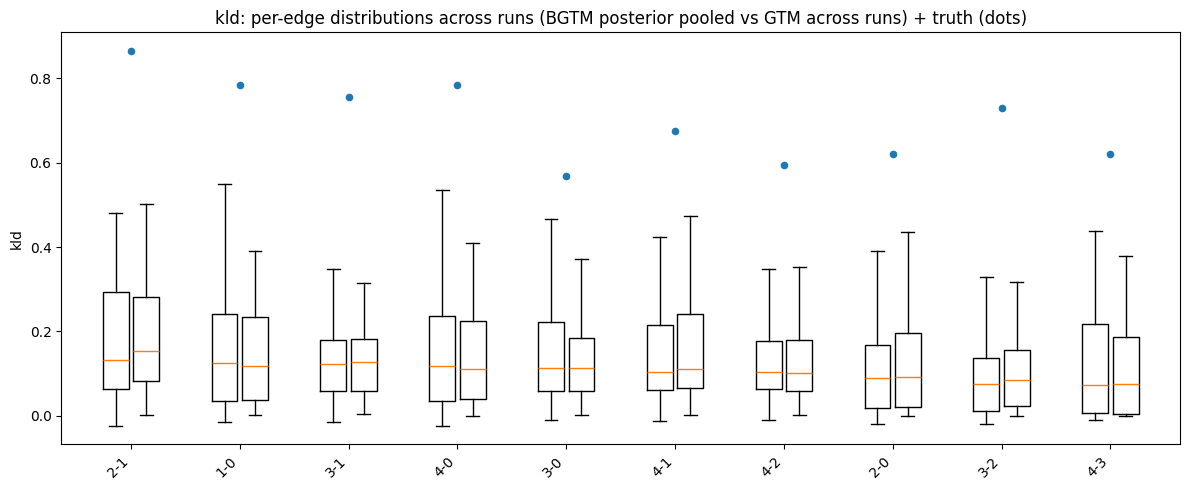

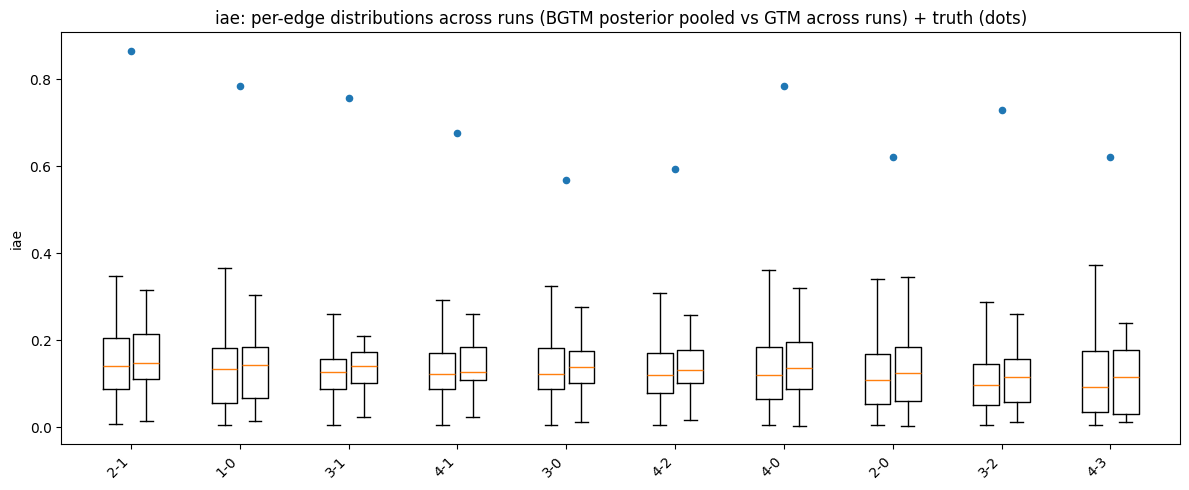

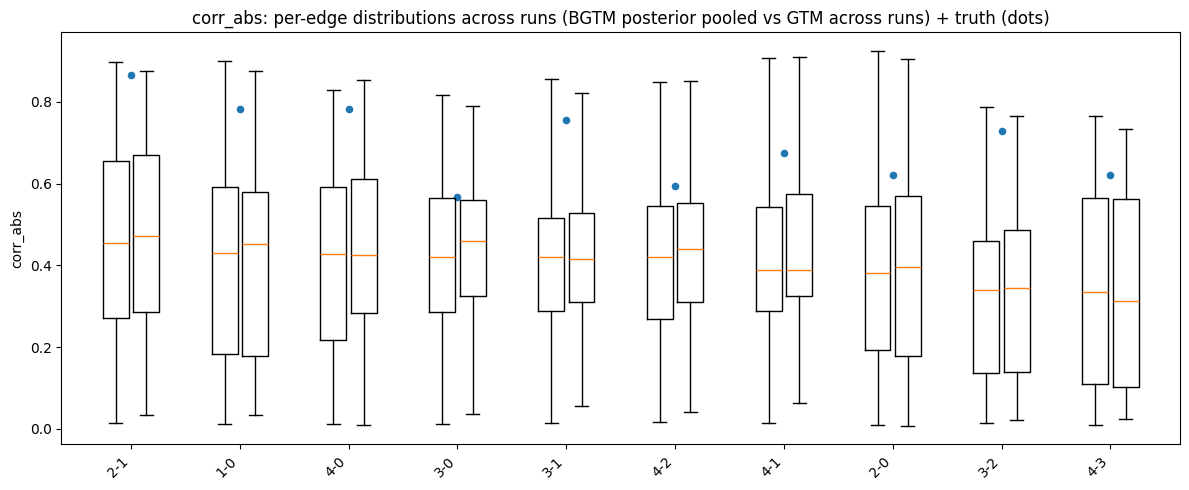

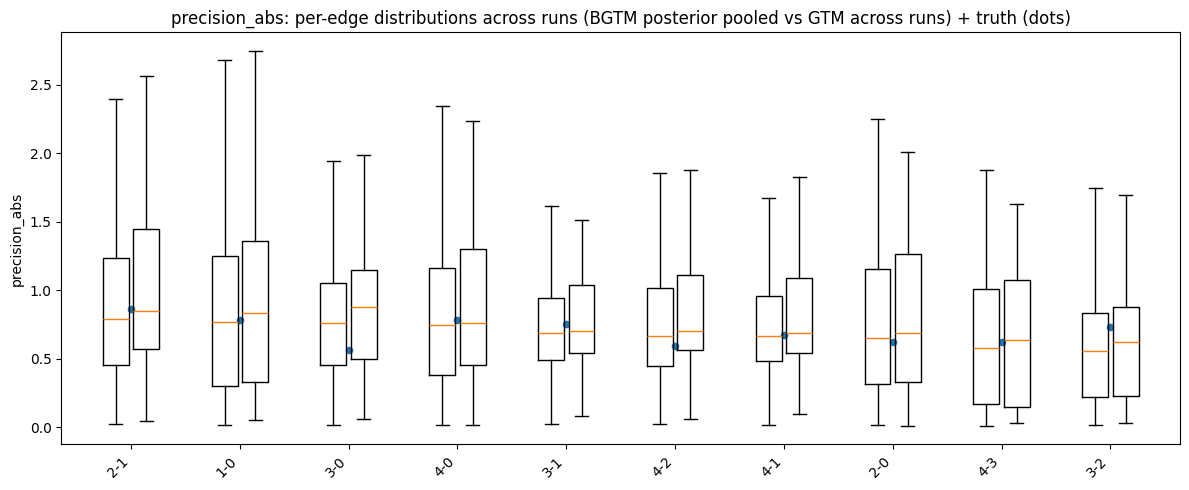

In [40]:
plot_edge_boxplots(runs, metric="kld", top_k=25)
plot_edge_boxplots(runs, metric="iae", top_k=25)
plot_edge_boxplots(runs, metric="corr_abs", top_k=25)
plot_edge_boxplots(runs, metric="precision_abs", top_k=25)
